In [ ]:
# default_exp core

# fastproaudio core

> API details.

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastai librosa torchaudio pyzenodo3 # for colab testing

In [ ]:
#export

#from fastai.vision.all import *
from fastai.data.all import *
#from subprocess import Popen, PIPE
import pyzenodo3
import torchaudio
import librosa
import librosa.display
from IPython.display import Audio 

#from zipfile import ZipFile

# some data urls
URLs.AUDIOMDPI = 'https://zenodo.org/record/3562442'
URLs.MARCO = URLs.AUDIOMDPI  # just a shorthand alias I'm more likely to remember
URLs.SIGNALTRAIN_LA2A_1_1 = 'https://zenodo.org/record/3824876'
URLs.SIGNALTRAIN_LA2A_REDUCED = 'http://hedges.belmont.edu/data/SignalTrain_LA2A_Reduced.tgz'

Some audio data urls: 

URLs.AUDIOMDPI = 'https://zenodo.org/record/3562442'

URLs.MARCO = URLs.AUDIOMDPI  # just a shorthand alias I'm more likely to remember

URLs.SIGNALTRAIN_LA2A_1_1 = 'https://zenodo.org/record/3824876'

URLs.SIGNALTRAIN_LA2A_REDUCED = 'http://hedges.belmont.edu/data/SignalTrain_LA2A_Reduced.tgz'

In [ ]:
#export
def zenodo_url_to_data_url(url):
    #%pip install pyzenodo3 -q
    zen = pyzenodo3.Zenodo()
    record = url.split('/')[-1]
    return zen.get_record(record).data['files'][0]['links']['self']  

In [ ]:
#slow
print(URLs.MARCO)
print(zenodo_url_to_data_url(URLs.MARCO))

https://zenodo.org/record/3562442
https://zenodo.org/api/files/d6589bb4-d6a6-4bc6-8e51-e6334fafbe3f/AudioMDPI.zip


In [ ]:
#slow
print(URLs.SIGNALTRAIN_LA2A_1_1)
print(zenodo_url_to_data_url(URLs.SIGNALTRAIN_LA2A_1_1))

https://zenodo.org/record/3824876
https://zenodo.org/api/files/df302f12-7355-452e-93d1-b0c9344608f7/SignalTrain_LA2A_Dataset_1.1.tgz


In [ ]:
#export 

# extract_func no longer supported  in untar_data, so zipfile stuff is unused
# thanks KevinB for the zip_extract! https://forums.fast.ai/t/generalizing-untar-data-to-also-work-with-zips/53741/14?u=drscotthawley
#def zip_extract(fname, dest):
#    zipfile.ZipFile(fname, mode='r').extractall(dest)

def get_audio_data(url):
    if ('zenodo' in url.lower()):
        url = zenodo_url_to_data_url(url)
    if '.zip' in url[-5:]:
        return untar_data(url)#, extract_func=zip_extract) #
    else:
        return untar_data(url) 

Try downloading a sample .tgz file

In [ ]:
#slow
path_st = get_audio_data(URLs.SIGNALTRAIN_LA2A_REDUCED)
path_st

Path('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced')

And try downloading from a Zenodo URL:

In [ ]:
#slow
path_audiomdpi = get_audio_data(URLs.MARCO)
path_audiomdpi

Path('/home/shawley/.fastai/data/AudioMDPI')

In [ ]:
#all_slow

Let's use this data as an example and take a look at it:

In [ ]:
path_audiomdpi.ls()

(#4) [Path('/home/shawley/.fastai/data/AudioMDPI/LeslieWoofer'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn'),Path('/home/shawley/.fastai/data/AudioMDPI/license.txt'),Path('/home/shawley/.fastai/data/AudioMDPI/6176ChannelStrip')]

We'll grab the `LeslieHorn` subset

In [ ]:
horn = path_audiomdpi / "LeslieHorn"; horn.ls()

(#4) [Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/readme.txt'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/chorale'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/tremolo'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/dry')]

In [ ]:
path_dry = horn /'dry'
#path_trem = horn / 'tremolo'
audio_extensions = ['.m3u', '.ram', '.au', '.snd', '.mp3','.wav']
fnames_dry = get_files(path_dry, extensions=audio_extensions)
#fnames_trem = get_files(path_trem, extensions=audio_extensions)

In [ ]:
waveform, sample_rate = torchaudio.load(fnames_dry[0])

Let's take a look at it:

In [ ]:
#export 
def show_audio(waveform, sample_rate):
    "This display routine is an amalgam of the torchaudio tutorial and the librosa documentation:"
    
    # print stats:
    print("Shape:", tuple(waveform.shape), "Dtype:", waveform.dtype)
    print(f"Max: {waveform.max().item():6.3f},  Min: {waveform.min().item():6.3f}, Mean: {waveform.mean().item():6.3f}, Std Dev: {waveform.std().item():6.3f}")

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    # waveform, from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
    for c in range(num_channels):
        label = f'Channel {c+1}' if num_channels > 1 else ''
        ax[0].plot(time_axis, waveform[c], linewidth=1, label=label)
    ax[0].grid(True)
    ax[0].title.set_text('Waveform')
    if num_channels > 1: ax[0].legend()
    
    # mel spectrogram  for channel_0, code from librosa documentation
    y, sr = waveform[0], sample_rate
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax[1])
    ax[1].set(title='Mel spectrogram display')
    fig.colorbar(img, ax=ax[1], format="%+2.f dB")
    plt.show()

    # play audio 
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


Shape: (1, 110250) Dtype: torch.float32
Max:  1.000,  Min: -0.973, Mean: -0.000, Std Dev:  0.086


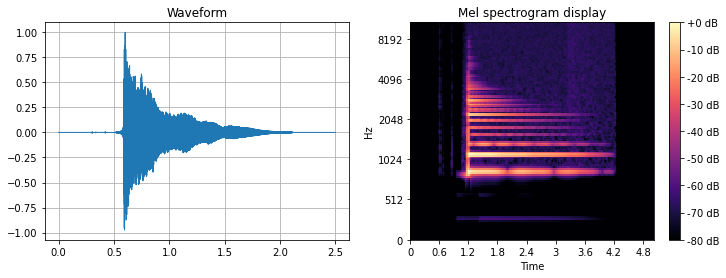

In [ ]:
#slow
show_audio(waveform, sample_rate)